In [145]:
# lets import xarray and numpy
%matplotlib inline
%config InlineBackend.figure_format='retina'
import IPython.display

import matplotlib.pyplot as plt
import datetime
import pandas as pd
import xarray as xr
import numpy as np
import os
import pathlib

def pathto_dict(path, exp_list=None, level=0):
    for root, dirs, files in os.walk(path):
        #if (level == 3) & (pathlib.PurePath(root).name not in perm_exp):
            #continue
        #else:
        if level == 3:
            tree = {"name": pathlib.PurePath(root).name,"path": root, "type":"experiment", "children":[]}
        elif level == 2:
            tree = {"name": pathlib.PurePath(root).name,"path": root, "type":"model", "children":[]}
        elif level == 1:
            tree = {"name": pathlib.PurePath(root).name,"path": root, "type":"organisation", "children":[]}
        else:
            tree = {"name": pathlib.PurePath(root).name,"path": root, "type":"folder", "children":[]}
        tree["children"].extend([pathto_dict(os.path.join(root, d), exp_list=exp_list, level=level+1) for d in dirs])
        tree["children"].extend([{"name": f, "path":os.path.join(root, f), "type":"file"} for f in files])
        return tree

def find_dataset(mdict, exp=[], model=[], org=[]):
    mdat = next((sub for sub in mdict if (sub['name'] == org) & (sub['type']=='organisation')), None)
    if mdat is not None:
        expdat = next((sub for sub in mdat['children'] if (sub['name'] == model) & (sub['type']=='model')), None)
    else:
        print('Org not found')
        return None
    if expdat is not None:
        dat = []
        if isinstance(exp, list):
            for e in exp:
                dat.append(next((sub for sub in expdat['children'] if (sub['name'] == e) & (sub['type']=='experiment')), None))
        else:
            dat = [next((sub for sub in expdat['children'] if (sub['name'] == exp) & (sub['type']=='experiment')), None)]
    else:
        print('Model not found')
        return None
    if None not in dat:
        return dat #[datum['children'] for datum in dat]
    else:
        print('1 or more experiment not found')
        return [x for x in dat if x is not None]

def get_dataset(found_dataset, org):
    if len(found_dataset) == 1:
        filename = found_dataset[0]['path']+"/*.nc"
        try:
            ds_exp = xr.open_mfdataset(filename, decode_times=True)
        except:
            ds_exp = xr.open_mfdataset(filename, decode_times=False)
        return reassign_coords(ds_exp, org) 
    
    else:
        ds_exps = []
        exp_list = [exp['name'] for exp in found_dataset]
        
        for i in range(len(found_dataset)):
            filename = found_dataset[i]['path']+"/*.nc"
            try:
                ds_exp = xr.open_mfdataset(filename, decode_times=True)
            except:
                ds_exp = xr.open_mfdataset(filename, decode_times=False)
            ds_exps.append(reassign_coords(ds_exp, org)) # some experiment have inconsistent time coords within a given model
        ds_model = xr.concat(ds_exps, pd.Index(exp_list, name='experiment'))

    return ds_model

def get_datetimes(ds_exp, org):

    if org in ['UTAS','UTAS','UCIJPL','ILTS_PIK','PIK','JPL1','LSCE','DOE','AWI','VUW']:
        dt = ds_exp.indexes['time'].to_datetimeindex()

    elif org in ['NCAR','IMAU','ULB']:
        dt = ds_exp.indexes['time']

    elif org == 'VUB':
        dtind = ds_exp.indexes['time']
        dt = pd.DatetimeIndex([datetime.datetime.fromtimestamp(time_ind - (1969*3.154e+7)) for time_ind in dtind])

    return dt

def reassign_coords(ds_exp, org):
    
    GRID_COUNT = 761 ## this is the same for every model!
    GRID_EXTENT = 3040 # km
    x_km, y_km = np.linspace(-GRID_EXTENT, GRID_EXTENT, num=GRID_COUNT), np.linspace(-GRID_EXTENT, GRID_EXTENT, num=GRID_COUNT)
    LON, LAT = np.load('ismip6_lonlat_coords.npy')
    
    if org in ['UTAS','UCIJPL','IMAU','ULB','JPL1','DOE']: # 86 times, yearly data since 2015-1-1
    #IMAU STARTS AT 2015-07-01, ulb starts at 2015-11-05
        num_tt = 86
        t_year = np.arange(num_tt)
        ds_exp = ds_exp.assign_coords(x=("x", x_km),y=("y", y_km),time=("time", t_year))
    
    elif org in ['VUW','NCAR','VUB']: #87 time points, yearly data since 2015-1-1, drop the extra year
        num_tt = 87
        t_year = np.arange(num_tt)
        ds_exp = ds_exp.assign_coords(x=("x", x_km),y=("y", y_km),time=("time", t_year))
        ds_exp = ds_exp.isel(time=slice(0,86))

    elif org in ['ILTS_PIK','AWI']: #172 time points starting with 2015-07-01, 6-month data
        num_tt = 172
        t_year = np.arange(num_tt)/2
        ds_exp = ds_exp.assign_coords(x=("x", x_km),y=("y", y_km),time=("time", t_year))

        #remove 0.5 data points and average 
        a = ds_exp.sel(time=t_year[1::2])
        b = ds_exp.sel(time=t_year[::2])
        a = a.assign_coords(time=("time", t_year[::2]))
        b = b.assign_coords(time=("time", t_year[::2]))
        ab = xr.concat([a,b], pd.Index(['start','mid'], name='halfyear'))
        ds_exp = ab.mean(dim='halfyear')
        
    elif org=='PIK': # 202 time points starting with 2015-07-01, 6-month data, extra 30 points
        num_tt = len(ds_exp.time) # 202 in pism1 and 200 in pism2
        t_year = np.arange(num_tt)/2
        
        #drop last 30 points
        ds_exp = ds_exp.assign_coords(x=("x", x_km),y=("y", y_km),time=("time", t_year))
        ds_exp = ds_exp.isel(time=slice(0,172))
        t_year = np.arange(172)/2

        #remove 0.5 data points and average
        a = ds_exp.sel(time=t_year[1::2])
        b = ds_exp.sel(time=t_year[::2])
        a = a.assign_coords(time=("time", t_year[::2]))
        b = b.assign_coords(time=("time", t_year[::2]))
        ab = xr.concat([a,b], pd.Index(['start','mid'], name='halfyear'))
        ds_exp = ab.mean(dim='halfyear')
        
    elif org=='LSCE': #173 time points, 6-month data starting with 2015-01-01, extra point
        num_tt = 173
        t_year = np.arange(num_tt)/2

        #drop last point
        ds_exp = ds_exp.assign_coords(x=("x", x_km),y=("y", y_km),time=("time", t_year))
        ds_exp = ds_exp.isel(time=slice(0,172))
        t_year = t_year[:-1]

        #remove 0.5 data points and average
        a = ds_exp.sel(time=t_year[1::2])
        b = ds_exp.sel(time=t_year[::2])
        a = a.assign_coords(time=("time", t_year[::2]))
        b = b.assign_coords(time=("time", t_year[::2]))
        ab = xr.concat([a,b], pd.Index(['start','mid'], name='halfyear'))
        ds_exp = ab.mean(dim='halfyear')
        
    ds_exp = ds_exp.assign_coords(lat=(("y", "x"), LAT), lon=(("y", "x"), LON))
    return ds_exp


## Load and combine different models and experiments into one dataset

The data arrays do not have consistent coordinates, so we need to set a simple coordinate system. For $(x,y)$ we'll use a grid with spacings of 1 km by 1 km, centered at (0,0). We know that the model output covers a range from -3040 to 3040 km in each direction. For time, we simply use integer values to represent the number of years that have passed (starting at 0 = year 2015).

In [31]:
inst_list = [pathlib.PurePath(f).name for f in os.scandir("/g/data/kj13/datasets/ismip6") if f.is_dir()]
models_dict = {}
for inst in inst_list:
    mdl_list = [pathlib.PurePath(f).name for f in os.scandir("/g/data/kj13/datasets/ismip6"+"/"+inst) if f.is_dir()]
    models_dict[inst] = mdl_list

model_dict = pathto_dict("/g/data/kj13/datasets/ismip6")['children']
print(models_dict.keys())

dict_keys(['UTAS', 'VUW', 'UCIJPL', 'NCAR', 'ILTS_PIK', 'IMAU', 'PIK', 'ULB', 'CPOM', 'JPL1', 'VUB', 'LSCE', 'DOE', 'AWI'])


In [175]:
#for org in models_dict.keys():
ds_models = []
#for org in ['AWI','DOE','ILTS_PIK','IMAU','LSCE','NCAR','UCIJPL','JPL1','ULB','VUB']: exp5 and exp7
#for org in ['DOE','UCIJPL','JPL1','ULB','IMAU']:
model_list = ['JPL1','NCAR']
exp_list = ['ctrl_proj_std','ctrl_proj','exp05','exp07']

for org in model_list:
    for model in models_dict[org]:
        print(org, model)
        #exp_list = [pathlib.PurePath(f).name for f in os.scandir("/g/data/kj13/datasets/ismip6/"+org+'/'+model) if f.is_dir()]
        found_data = find_dataset(model_dict, exp=exp_list, model=model, org=org)
        if found_data is None:
            continue
        model_data = get_dataset(found_data, org)
        ds_models.append(model_data)

#ism_dataset = xr.concat(ds_models, pd.Index(['PISM1','PISM2'], name='model'))

JPL1 ISSM
1 or more experiment not found
NCAR CISM
1 or more experiment not found


In [199]:
exp_list = ['ctrl_proj', 'exp05','exp07']

ds_models[1]['experiment'] = exp_list

In [190]:
ism_dataset = xr.concat(ds_models, pd.Index(model_list, name='model'))

We have added two extra dimensions to our dataset: experiment and model. In this demo we look at only two examples of each. 

In [203]:
ism_dataset.model.attrs = {'JPL1':'JPL1_ISSM_std', 'NCAR':'NCAR_CISM_std'}
ism_dataset.experiment.attrs = {'exp05':'NorESM1 RCP 8.5', 'exp07':'NorESM1 RCP 2.6', 'ctrl_proj':'Control'}

## Functions for computing ice mass and sea level rise

First we need the total volume of grounded ice. This is done by summing up the product of the ice thickness $h$ with the grid area $\textrm{d}A$ over all grid points $i$, scaled by the fraction of that grid area for which that ice is grounded $F_{\text{grounded}}$: $V_{\text{grounded}} = \sum_i \left( h_{\text{i}} \times \textrm{d}A_i \times F_{\text{grounded},i} \right)$ 

Then, in order to find the volume of water that would be displaced by this ice, we need to scale by the ratios of density:
$V_{\text{water}} = V_{\text{grounded}} \times \frac{\rho_{\text{ice}}}{\rho_{\text{seawater}}}$

Finally, to get the rise in the sea level, $\Delta h$, we use the surface area of the ocean, $A_{\text{ocean}}$:
$\Delta h = \frac{V_{\text{water}}}{A_{\text{ocean}}} \times 10^6 \, \text{mm}$

In [192]:
# Constants
ICE_DENSITY = 0.917 # in Gt / km ^3
WATER_DENSITY = 1.027  # Gt / km ^3
OCEAN_SURFACE_AREA = 361.8 * 10**6  # km²

def sea_level_rise(grounded_ice_mass_gt):

    # Convert grounded ice mass to water equivalent volume (in km³)
    water_volume_km3 = grounded_ice_mass_gt * (ICE_DENSITY / WATER_DENSITY)

    # Calculate the sea level rise in mm
    sea_level_rise_mm = (water_volume_km3 / OCEAN_SURFACE_AREA) * 10**6  # mm

    return sea_level_rise_mm

def get_ice_mass_area(lithk, fraction=None):
    
    thickness =  lithk * 1e-3 # convert to km units
    
    ones_array = xr.DataArray(np.ones_like(thickness), coords=thickness.coords, dims=thickness.dims)
    masked_ones = ones_array.where(~np.isnan(thickness))
    
    # Mask the DataArray to replace NaNs with 0
    masked_data = thickness.where(~np.isnan(thickness), other=0)
    if fraction is not None:
        fraction = fraction.where(~np.isnan(fraction), other=0)
        masked_data *= fraction
        masked_ones *= fraction
    
    # Integrate over the x and y coordinates
    dx = np.gradient(thickness.coords['x']) # in km 
    dy = np.gradient(thickness.coords['y']) # in km 
    
    # Create an area array if the grid spacing varies
    integrated_area = (masked_ones * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    integrated_area = integrated_area.compute()/1e7 # in 1e7 km ^2
    
    volume = (masked_data * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    volume = volume.compute() # in km ^3
    
    ice_mass = volume*ICE_DENSITY/1e7 # convert to Gt 1e7 units
    
    return ice_mass, integrated_area

### Let's compute the mass of land ice at the beginning of the experiment

In [193]:
issm_ctrl = ism_dataset.sel(model='JPL1',experiment='ctrl_proj')

total_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0))
print(total_ice[0].item()*1e7,' Gt of total ice at beginning of experiment')

floating_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0),fraction=issm_ctrl.sftflf.isel(time=0))
print(floating_ice[0].item()*1e7,' Gt of floating ice at beginning of experiment')

grounded_ice = get_ice_mass_area(issm_ctrl.lithk.isel(time=0),fraction=issm_ctrl.sftgrf.isel(time=0))
print(grounded_ice[0].item()*1e7,' Gt of grounded ice at beginning of experiment')

# NOTE: 
# lithk = orog - base (ice thickness = surface altitude - base altitude)
# ice thickness = floating ice + grounded ice

23768200.854807228  Gt of total ice at beginning of experiment
564181.2112791991  Gt of floating ice at beginning of experiment
23204019.64352803  Gt of grounded ice at beginning of experiment


## Compute Sea level contribution and combine with existing dataset

We want to compare the results of each experiment with the 'control', so we need to find the relative sea level rise.

In [201]:
num_model = len(model_list)
num_exp = len(exp_list)
num_tt = len(ism_dataset.coords['time'])

mmSLE = xr.DataArray(
    np.zeros((num_tt, num_exp, num_model)),
    dims=['time', 'experiment', 'model'],
    coords={
        'time': ism_dataset.coords['time'],
        'experiment': exp_list,
        'model': model_list
    },
    name='mmsle'  # Name of the new variable
)

for i in range(num_model):
    model = model_list[i]
    ism_model = ism_dataset.sel(model=model)
    ice_mass_ctrl = get_ice_mass_area(ism_model.sel(experiment='ctrl_proj').lithk,fraction=ism_model.sel(experiment='ctrl_proj').sftgrf.isel(time=0))[0]
    for j in range(num_exp):
        exp = exp_list[j]
        ice_mass_exp = get_ice_mass_area(ism_model.sel(experiment=exp).lithk,fraction=ism_model.sel(experiment=exp).sftgrf.isel(time=0))[0]
        ice_above_floatation = ice_mass_exp.values - ice_mass_ctrl.values
        sle = sea_level_rise(-ice_above_floatation*1e7)
        mmSLE.sel(experiment=exp,model=model)[:] = sle
        
ism_dataset['mmsle'] = mmSLE

## Save the dataset as an nc file

In [532]:
#filename = './ISMIP6_output.nc'
#print ('saving to ', filename)
#ism_dataset.to_netcdf(path=filename)

## Reproducing Figure 4

Figure 4 shows the evolution of ice volume above floatation (in mm SLE) over 2015-2100 from the NorESM1-M RCP 8.5 scenario (exp05) relative to ctrl_proj.

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, -60.0, '−60'),
  Text(0, -40.0, '−40'),
  Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100')])

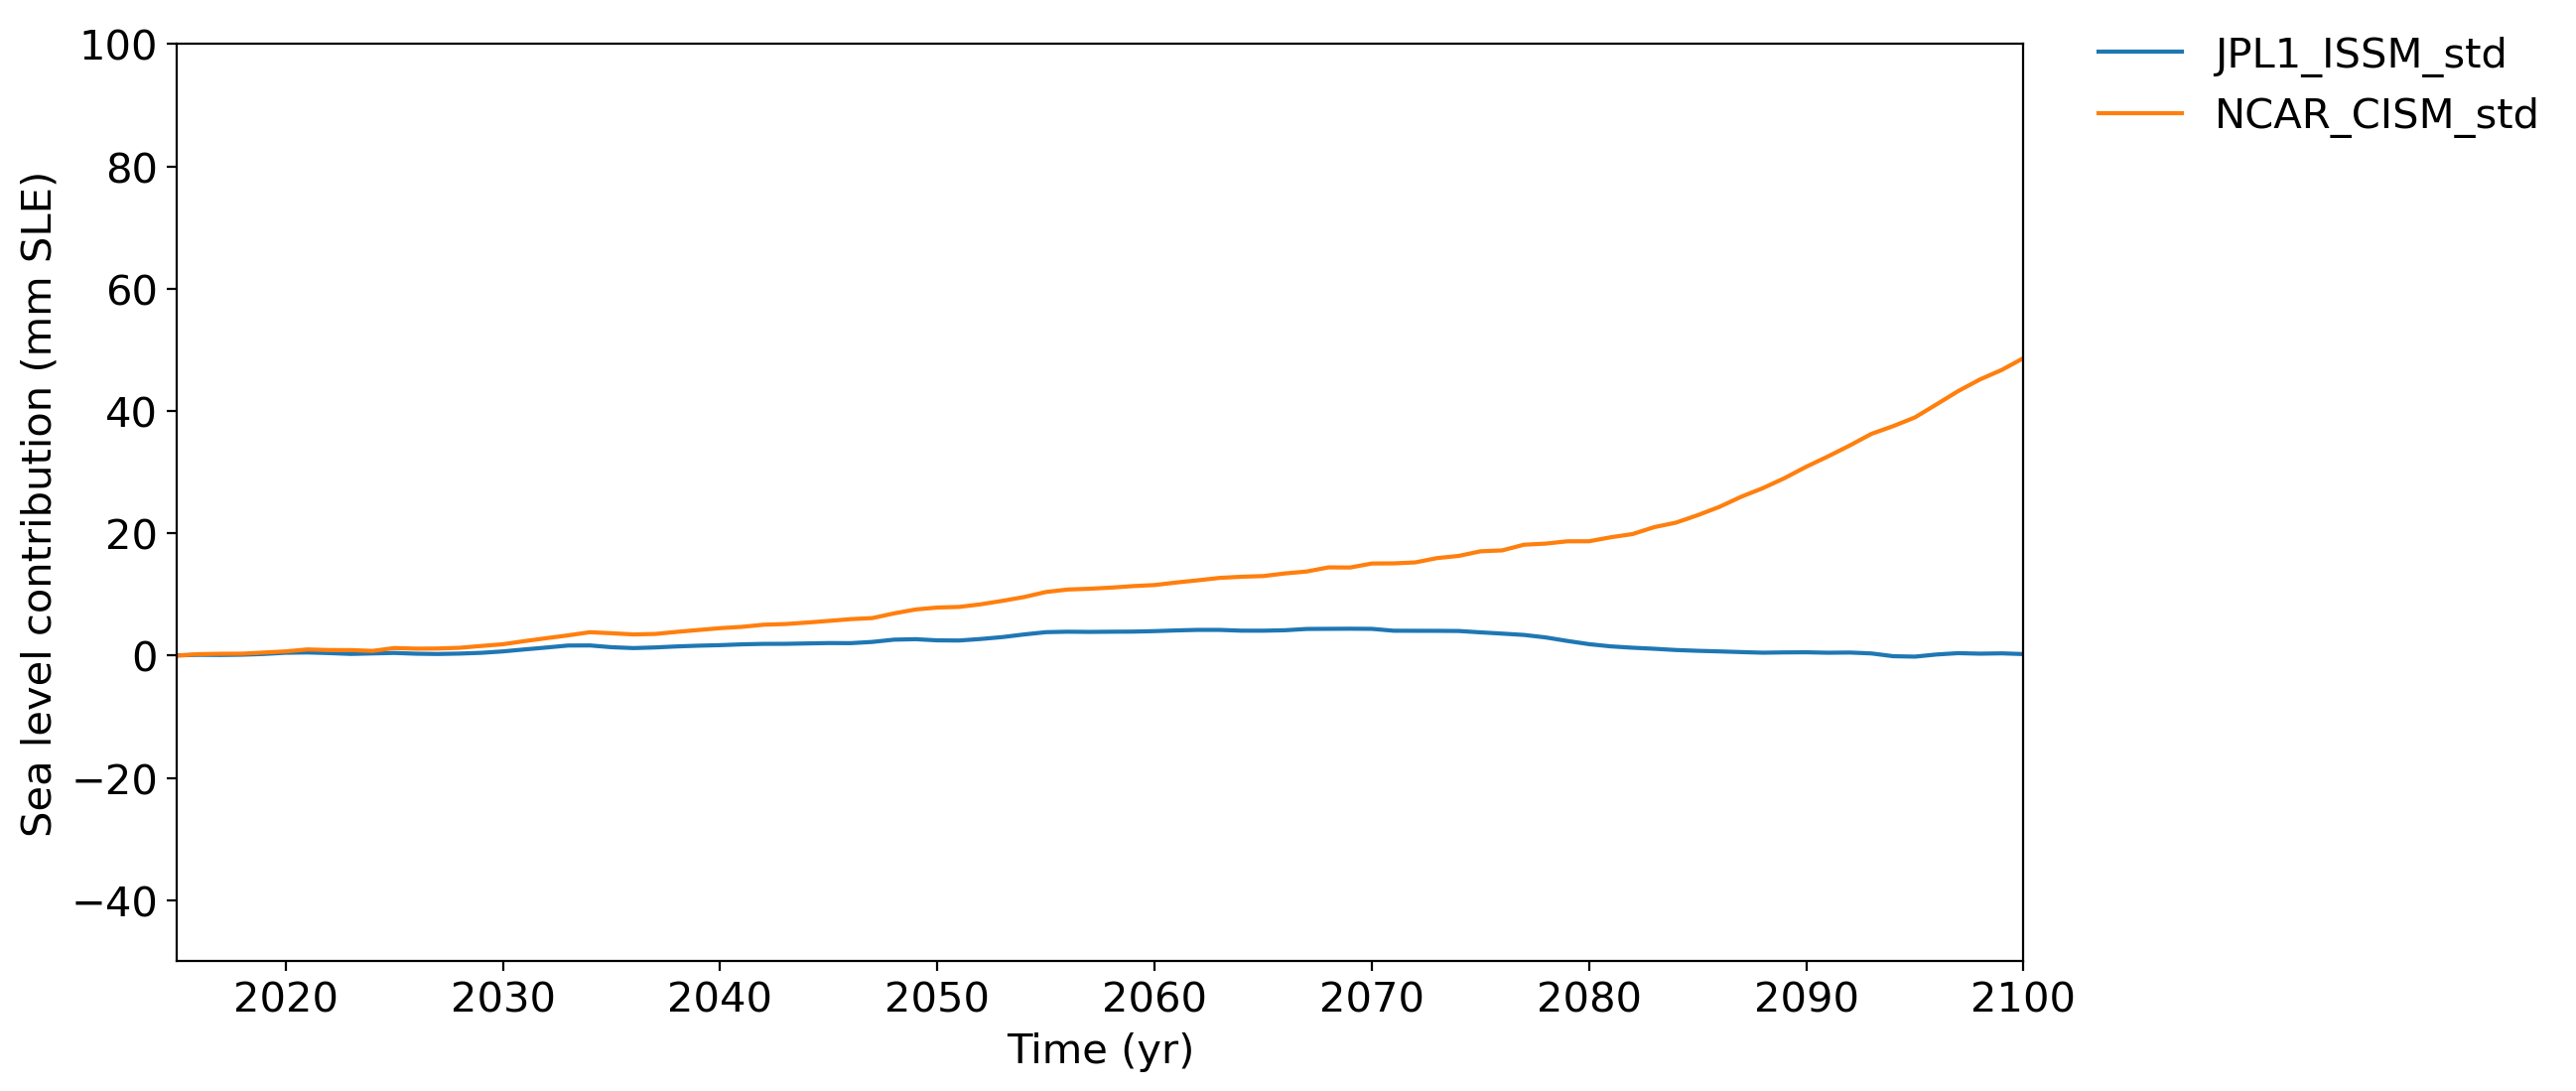

In [204]:
# Fig 4 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
plt.figure(figsize=(12,6))

years = 2015 + np.arange(num_tt)

for model in model_list:
    plt.plot(years, ism_dataset.sel(model=model).sel(experiment='exp05').mmsle, label=ism_dataset.model.attrs[model])

plt.legend(fontsize=15, bbox_to_anchor=(1.3, 1.05), frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)', fontsize=15)
plt.xlabel('Time (yr)', fontsize=15)
plt.ylim(-50,100)
plt.xlim(2015, 2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Reproducing Figure 6

Figure 6 Mean (left) and standard deviation (right) of simulated thickness change (in m) between 2015 and 2100 under medium forcing from the NorESM1-M RCP 8.5 scenario (exp05) relative to ctrl_proj. 

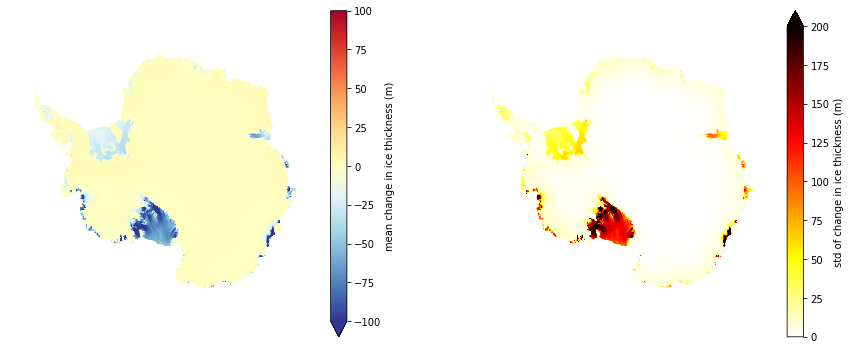

In [622]:
# Fig 6 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
fig, axs = plt.subplots(ncols=2, figsize=(15,6))

seconds_per_year = 60*60*24*365

## why multiply by number of years rather than the number of seconds??

# find the mean of tendency of land ice thickness in m/s
frac_land_ice = ism_dataset.sftgrf.sel(model='issm',experiment='exp05',time=0)
mean_thickness = num_tt*ism_dataset.sel(experiment='exp05').dlithkdt.mean(dim=['model','time'], skipna=True)
mean_thickness += frac_land_ice.where(np.isnan(frac_land_ice), other=0)

std_thickness = num_tt*ism_dataset.sel(experiment='exp05').dlithkdt.std(dim=['model','time'], skipna=True)
std_thickness += frac_land_ice.where(np.isnan(frac_land_ice), other=0)

im1 = mean_thickness.plot(ax=axs[0], cmap='RdYlBu_r', vmin=-100, vmax=100)
im2 = std_thickness.plot(ax=axs[1], cmap='hot_r', vmin=0, vmax=200)
axs[0].set_title('')
axs[0].axis('off')
im1.colorbar.set_label('mean change in ice thickness (m)')

axs[1].set_title('')
axs[1].axis('off')
im2.colorbar.set_label('std of change in ice thickness (m)')

## Reproducing Figure 9

Figure 9 shows the impact of RCP scenario on projected evolution of ice volume above floatation for the NorESM1-M models. Red and blue curves show mean evolution for RCP 8.5 and RCP 2.6, respectively, and the shaded background shows the standard deviation. (only 2 models are used here)

(array([-40., -20.,   0.,  20.,  40.,  60.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

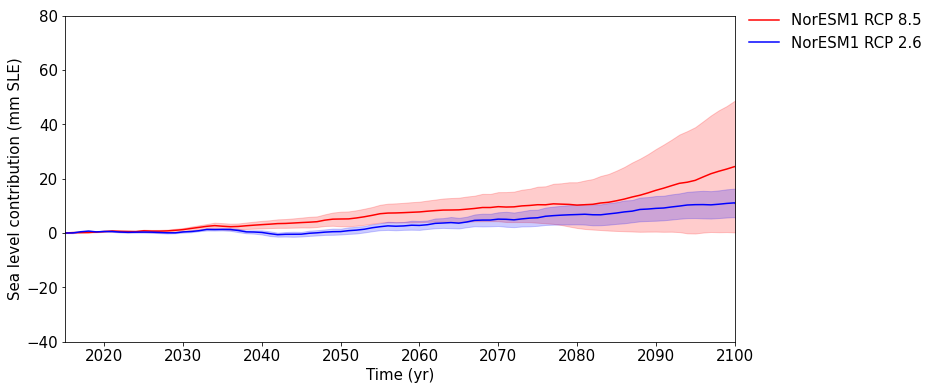

In [538]:
# Fig 9 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
plt.figure(figsize=(12,6))

colors = {'exp05':'red','exp07':'blue'}

for exp in exp_list:
    mean_SLE = ism_dataset.sel(experiment=exp).mmsle.mean(dim='model', skipna=True)
    std_SLE = ism_dataset.sel(experiment=exp).mmsle.std(dim='model', skipna=True)

    plt.plot(years, mean_SLE, color=colors[exp], label=ism_dataset.experiment.attrs[exp])
    plt.fill_between(years, mean_SLE+std_SLE, mean_SLE-std_SLE, color=colors[exp], alpha=0.2)
    
plt.legend(fontsize=15, bbox_to_anchor=(1.3, 1.05), frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)', fontsize=15)
plt.xlabel('Time (yr)', fontsize=15)
plt.ylim(-40,80)
plt.xlim(2015, 2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)